In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd

import scipy
from scipy import signal

import rstoolbox as rs

In [4]:
rs.utils.format_Ipython()

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import matplotlib.patches as mpatches

In [6]:
print(np.__version__, pd.__version__, scipy.__version__, rs.__version__, matplotlib.__version__)

1.16.3 0.24.0 1.3.0 0.9.1 2.2.3


# MALS

In [7]:
df_acrWT_mals_uv = pd.read_pickle('acrWT_tev.mals_uv.pkl')
df_acrWT_mals_mw = pd.read_pickle('acrWT_tev.mals_mw.pkl')

df_acrX_mals_uv = pd.read_pickle('acrX_tev.mals_uv.pkl')
df_acrX_mals_mw = pd.read_pickle('acrX_tev.mals_mw.pkl')

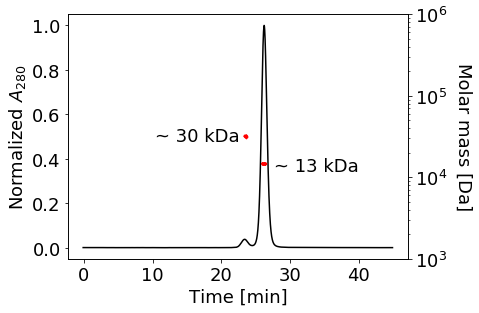

In [8]:
fig = plt.figure(figsize=(7, 4.7))
ax1 = plt.subplot2grid((1, 1), (0, 0))

ax1.plot(df_acrWT_mals_uv ['time (min)'], df_acrWT_mals_uv ['UV'], color='black',)
ax11 = ax1.twinx()

ax11.scatter(df_acrWT_mals_mw.loc[50:90]['time (min)'], 
             df_acrWT_mals_mw.loc[50:90]['Molar Mass 1'], 
             color='red', s=0.5,)
ax11.scatter(df_acrWT_mals_mw.loc[50:120]['time (min).1'], 
             df_acrWT_mals_mw.loc[50:120]['Molar Mass 2'], 
             color='red', s=0.5,)

ax11.set_ylim(10e2, 10e5)
ax11.set_yscale('log')

ax1.set_xlabel('Time [min]')
ax1.set_ylabel('Normalized $A_{280}$')
ax11.set_ylabel('Molar mass [Da]', rotation=270, labelpad=25)

ax1.text(.38, .5,'~ 30 kDa', horizontalalignment='center', verticalalignment='center', transform = ax1.transAxes)
ax1.text(.73, .38,'~ 13 kDa', horizontalalignment='center', verticalalignment='center', transform = ax1.transAxes)

plt.tight_layout()
#plt.savefig('acrWT.mals.svg', dpi=300, transparent=True)
plt.show()

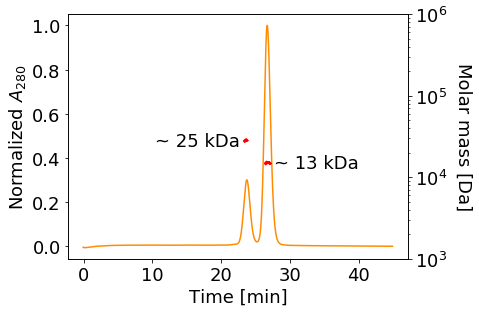

In [9]:
fig = plt.figure(figsize=(7, 4.7))
ax3 = plt.subplot2grid((1, 1), (0, 0))

ax3.plot(df_acrX_mals_uv['time (min)'], df_acrX_mals_uv['UV'], color='darkorange', label='UV AcrX')
ax33 = ax3.twinx() 

ax33.scatter(df_acrX_mals_mw.loc[50:100]['time (min)'], 
             df_acrX_mals_mw.loc[50:100]['Molar Mass 1'], 
             color='red', s=0.5,)

ax33.scatter(df_acrX_mals_mw.loc[70:160]['time (min).1'], 
             df_acrX_mals_mw.loc[70:160]['Molar Mass 2'], 
             color='red', s=0.5,)
             
ax33.set_ylim(10e2, 10e5)
ax33.set_yscale('log')

ax3.set_xlabel('Time [min]')
ax3.set_ylabel('Normalized $A_{280}$')
ax33.set_ylabel('Molar mass [Da]', rotation=270, labelpad=25)

ax3.text(.38, .48,'~ 25 kDa', horizontalalignment='center', verticalalignment='center', transform = ax3.transAxes)
ax3.text(.73, .39,'~ 13 kDa', horizontalalignment='center', verticalalignment='center', transform = ax3.transAxes)

plt.tight_layout()
#plt.savefig('acrX.mals.svg', dpi=300, transparent=True)
plt.show()

## CD

In [10]:
# Read files
df_acrWT_cd = pd.read_pickle('acrWT_tev.cd.pkl')
df_acrX_cd  = pd.read_pickle('acrX_tev.cd.pkl')

In [11]:
df_acrWT_cd['MRE'] = df_acrWT_cd[['CircularDichroism']].mean(axis=1)
df_acrX_cd['MRE']  = df_acrX_cd[['CircularDichroism']].mean(axis=1)

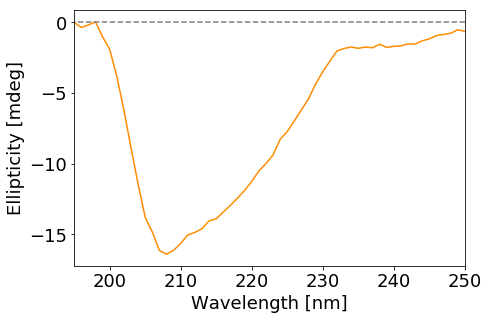

In [12]:
fig = plt.figure(figsize=(7, 4.7))
ax = plt.subplot2grid((1, 1), (0, 0))

rs.plot.plot_CD(df_acrX_cd, ax, color='darkorange')

ax.set_ylabel('Ellipticity [mdeg]')
ax.set_xlabel('Wavelength [nm]')
ax.set_title('')

#plt.savefig('acrX.cd.svg', dpi=300, transparent=True)
plt.show()

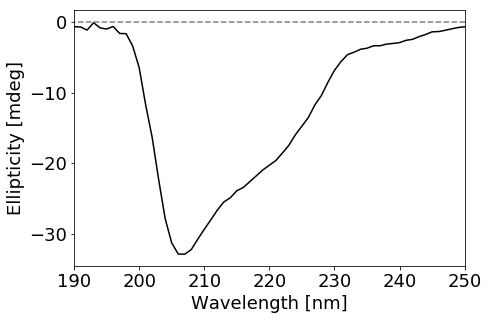

In [13]:
fig = plt.figure(figsize=(7, 4.7))
ax = plt.subplot2grid((1, 1), (0, 0))
rs.plot.plot_CD(df_acrWT_cd, ax, color='black')

ax.set_ylabel('Ellipticity [mdeg]')
ax.set_xlabel('Wavelength [nm]')
ax.set_title('')

#plt.savefig('acrWT.cd.svg', dpi=300, transparent=True)
plt.show()

In [14]:
minima_X = df_acrX_cd.iloc[df_acrX_cd['MRE'].idxmin()]
print("Minima acrX @ {}".format(minima_X.Wavelength))

Minima acrX @ 208


In [15]:
minima_WT = df_acrWT_cd.iloc[df_acrWT_cd['MRE'].idxmin()]
print("Minima acrWT @ {}".format(minima_WT.Wavelength))

Minima acrWT @ 207


# Thermal Melting

In [16]:
def sigmoid(x, L ,x0, k, b):
    """
    Sigmoid function.
    """
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

In [17]:
df_acrWT_tm = pd.read_pickle('acrWT_tev.tm.pkl')
df_acrX_tm  = pd.read_pickle('acrX_tev.tm.pkl')

In [18]:
xdata = df_acrWT_tm.loc['CircularDichroism'].loc['1'][[218]].index.values.flatten()
ydata = df_acrWT_tm.loc['CircularDichroism'].loc['1'][[218]].values.flatten()

p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess

popt, pcov = scipy.optimize.curve_fit(sigmoid, xdata, ydata, p0, method='dogbox')

# get half max
vals = [i*0.01 for i in range(0, int(100*xdata.max()))]
points = {
    'x': [],
    'y': []
}
for i in vals:
    r = sigmoid(i, *popt)
    points['x'].append(i)
    points['y'].append(r)
dfp = pd.DataFrame(points)
params = dfp.iloc[(dfp.y-((dfp.y.min()+dfp.y.max())/2)).abs().argsort()[:1]]
print('Tm = {}'.format(params.x.values[0]))

Tm = 66.32000000000001


/Users/hartevel/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp


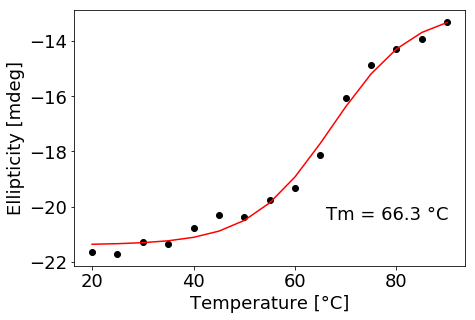

In [19]:
fig = plt.figure(figsize=(7, 4.7))
ax = plt.subplot2grid((1, 1), (0, 0))

ax.scatter(xdata, ydata, color='black')
ax.plot(xdata, sigmoid(xdata, *popt), color='red')

patch_2 = mpatches.Patch(color='black', label='AcrIIC1')

ax.set_xlabel('Temperature [°C]')
ax.set_ylabel('Ellipticity [mdeg]')

ax.text(.8, .2,'Tm = 66.3 °C', horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)

#plt.savefig('acrWT.tm.svg', dpi=300, transparent=True)
plt.show()

In [20]:
xdata = df_acrX_tm.loc['CircularDichroism'].loc['1'][[218]].index.values.flatten()
ydata = df_acrX_tm.loc['CircularDichroism'].loc['1'][[218]].values.flatten()

p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess

popt, pcov = scipy.optimize.curve_fit(sigmoid, xdata, ydata, p0, method='dogbox')

# get half max
vals = [i*0.01 for i in range(0, int(100*xdata.max()))]
points = {
    'x': [],
    'y': []
}
for i in vals:
    r = sigmoid(i, *popt)
    points['x'].append(i)
    points['y'].append(r)
dfp = pd.DataFrame(points)
params = dfp.iloc[(dfp.y-((dfp.y.min()+dfp.y.max())/2)).abs().argsort()[:1]]
print('Tm = {}'.format(params.x.values[0]))

Tm = 66.77


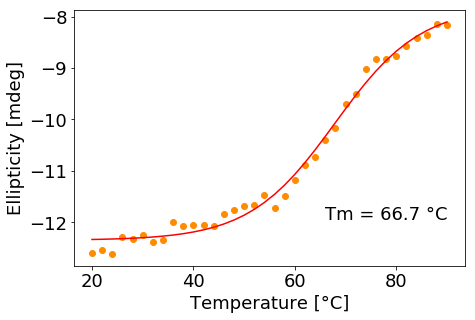

In [21]:
fig = plt.figure(figsize=(7, 4.7))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.scatter(xdata, ydata, color='darkorange')
ax.plot(xdata, sigmoid(xdata, *popt), color='red')

patch_2 = mpatches.Patch(color='darkorange', label='AcrX')

ax.set_xlabel('Temperature [°C]')
ax.set_ylabel('Ellipticity [mdeg]')
ax.text(.8, .2,'Tm = 66.7 °C', horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)

#plt.savefig('acrX.tm.svg', dpi=300, transparent=True)
plt.show()

## SPR

In [22]:
df_acrWT_sau_spr = pd.read_pickle('acrWT_sau.spr.pkl')
df_acrWT_nme_spr = pd.read_pickle('acrWT_nme.spr.pkl')

df_acrX_sau_spr  = pd.read_pickle('acrX_sau.spr.pkl')
df_acrX_nme_spr  = pd.read_pickle('acrX_nme.spr.pkl')

/Users/hartevel/anaconda3/lib/python3.5/site-packages/rstoolbox/plot/experimental.py:607: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  conc = sorted(set(df['fitted'].columns.labels[0]))


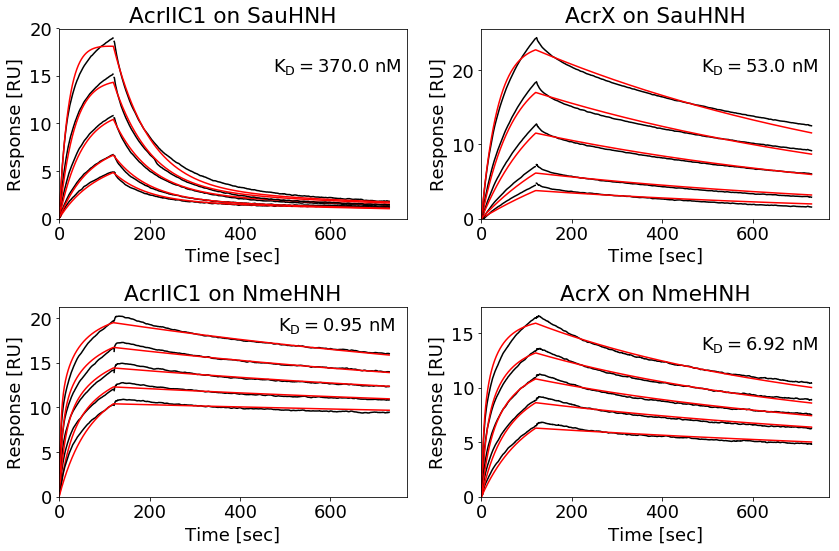

In [23]:
fig = plt.figure(figsize=(12, 8.))

grid = (2, 2)
ax01 = plt.subplot2grid(grid, (0, 0))
ax02 = plt.subplot2grid(grid, (0, 1), )

ax11 = plt.subplot2grid(grid, (1, 0))
ax12 = plt.subplot2grid(grid, (1, 1))


rs.plot.experimental.plot_SPR(df_acrWT_sau_spr, ax=ax01, datacolor='black', fitcolor='red',)
ax01.set_title('AcrIIC1 on SauHNH')
ax01.set_xlabel('Time [sec]')
ax01.set_ylabel('Response [RU]')
ax01.text(.8, .8,'$\mathregular{K_{D}} = 370.0$ nM', horizontalalignment='center', verticalalignment='center', transform = ax01.transAxes)


rs.plot.experimental.plot_SPR(df_acrX_sau_spr, ax=ax02, datacolor='black', fitcolor='red',)
ax02.set_title('AcrX on SauHNH')
ax02.set_xlabel('Time [sec]')
ax02.set_ylabel('Response [RU]')
ax02.text(.8, .8,'$\mathregular{K_{D}} = 53.0$ nM', horizontalalignment='center', verticalalignment='center', transform = ax02.transAxes)


rs.plot.experimental.plot_SPR(df_acrWT_nme_spr, ax=ax11, datacolor='black', fitcolor='red',)
ax11.set_title('AcrIIC1 on NmeHNH')
ax11.set_xlabel('Time [sec]')
ax11.set_ylabel('Response [RU]')
ax11.text(.8, .9,'$\mathregular{K_{D}} = 0.95$ nM', horizontalalignment='center', verticalalignment='center', transform = ax11.transAxes)


rs.plot.experimental.plot_SPR(df_acrX_nme_spr, ax=ax12, datacolor='black', fitcolor='red',)
ax12.set_title('AcrX on NmeHNH')
ax12.set_xlabel('Time [sec]')
ax12.set_ylabel('Response [RU]')
ax12.text(.8, .8,'$\mathregular{K_{D}} = 6.92$ nM', horizontalalignment='center', verticalalignment='center', transform = ax12.transAxes)

plt.tight_layout()